# TensorFlow的线性回归
## 用TensorFlow求逆矩阵
base

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sess = tf.Session()

初始化计算图，并生成数据和计算所需矩阵</p>
线性公式为：$ wX=b $
求解方式为：$ X=(w^{T}w)^{-1}w^{T}b $

In [3]:
x = np.linspace(0, 10 ,100)
y = x + np.random.normal(0,1,100)
                         
x_transpose = np.transpose(np.matrix(x))
one_x_transpose = np.transpose(np.matrix(np.repeat(1,100)))
w = np.column_stack((x_transpose, one_x_transpose))
b = np.transpose(np.matrix(y))

将w,b的矩阵转化为张量

In [4]:
_w = tf.constant(w)
_b = tf.constant(b)

构建计算图模型

In [5]:
_w_inverse = tf.matrix_inverse(tf.matmul(tf.transpose(_w),_w))
product = tf.matmul(_w_inverse,tf.transpose(_w))
solution = tf.matmul(product,_b)
solution_eval = sess.run(solution)
slope = solution_eval[0][0]
y_intercept = solution_eval[1][0]

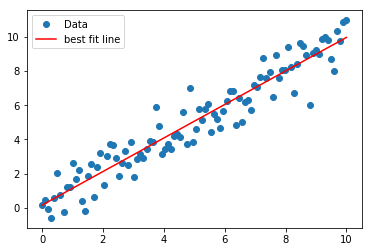

In [6]:
best_fit = []
for i in x:
    best_fit.append(slope*i+y_intercept)
plt.plot(x,y,'o',label='Data')
plt.plot(x,best_fit,'r-',label='best fit line')
plt.legend(loc='upper left')
plt.show()

## 工作原理

* 这里的解决方法是通过矩阵运算直接求解结果，</p>
* 大部分的TensoFlow算法是通过迭代训练，利用反向传播自动更新模型变量

## 用TensorFlow实现线性回归算法
* 这里我们是用常规的批量遍历数据更新参数的方法来处理。使用的数据依然是scikit-learn提供的iris数据集。
* 我们使用x的值代表花瓣的宽度，用y的值代表花瓣的长度。来找到最优的回归直线
* (选择这2个维度，是因为其具有线性关系..之后的可视化中可以看到)

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
#重新初始化tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

#读数据
iris = datasets.load_iris()
x  = np.array([i[3] for i in iris.data])
y  = np.array([j[0] for j in iris.data])

声明学习率，批次大小，迭代步数,占位符和模型变量

In [8]:
learning_rate = 0.05
batch_size = 25
epoch = 100

x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
_w = tf.Variable(tf.random_normal(shape=[1,1]))
_b = tf.Variable(tf.random_normal(shape=[1,1]))

线性模型公式： $ y=wx+b $

In [9]:
output = tf.add(tf.matmul(x_data,_w),_b)

L2损失函数,和梯度下降优化器

In [10]:
loss = tf.reduce_mean(tf.square(y_target - output))
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step = opt.minimize(loss)

初始化sess

In [11]:
init = tf.global_variables_initializer()
sess.run(init)

遍历迭代,并随机选择批量数据上进行模型训练。

In [12]:
loss_L2 = []
for i in range(epoch):
    rand_index = np.random.choice(len(x),size=batch_size)
    rand_x = np.transpose([x[rand_index]])
    rand_y = np.transpose([y[rand_index]])
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    train_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_L2.append(train_loss)
    if (i+1)%25 ==0:
        print('step : {} \t w= {}\t b={}'.format(i+1,sess.run(_w)[0][0],sess.run(_b)[0][0]))

step : 25 	 w= 1.689439058303833	 b=3.464118003845215
step : 50 	 w= 1.3455926179885864	 b=4.017512798309326
step : 75 	 w= 1.1522843837738037	 b=4.291538715362549
step : 100 	 w= 1.0919008255004883	 b=4.515878200531006


### 可视化回归曲线

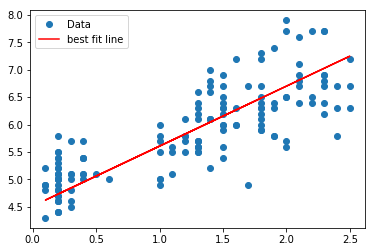

In [13]:
[slope] = sess.run(_w)
[y_intercept] = sess.run(_b)
best_fit = []
for i in x:
    best_fit.append(slope*i+y_intercept)
plt.plot(x,y,'o',label='Data')
plt.plot(x,best_fit,'r-',label='best fit line')
plt.legend(loc='upper left')
plt.show()

### 可视化Loss曲线

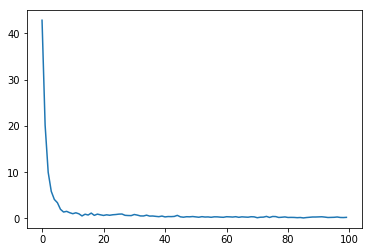

In [14]:
plt.plot(loss_L2)

可以看到Loss是有抖动的，这个抖动是与batch_size(批量大小)有关的，batch_size越大抖动越小。
## 工作原理

最优的直线并不能保证是最佳拟合的直线，最佳拟合直线的收敛依赖于迭代的次数、批量的大小、学习率及损失函数。</p>
最好时刻观察损失函数，来帮我们定位或者超参数调整。
### 下面我们使用L1正则，再改变batchsize来观察Loss的变化

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
#重新初始化tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

#读数据
iris = datasets.load_iris()
x  = np.array([i[3] for i in iris.data])
y  = np.array([j[0] for j in iris.data])

learning_rate = 0.1
batch_size = 50
epoch = 100

x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
_w = tf.Variable(tf.random_normal(shape=[1,1]))
_b = tf.Variable(tf.random_normal(shape=[1,1]))

output = tf.add(tf.matmul(x_data,_w),_b)

使用L1正则Loss函数

In [16]:
loss = tf.reduce_mean(tf.abs(y_target - output))
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step = opt.minimize(loss)

In [17]:
init = tf.global_variables_initializer()
sess.run(init)
loss_L1 = []
for i in range(epoch):
    rand_index = np.random.choice(len(x),size=batch_size)
    rand_x = np.transpose([x[rand_index]])
    rand_y = np.transpose([y[rand_index]])
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    train_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_L1.append(train_loss)
    if (i+1)%25 ==0:
        print('step : {} \t w= {}\t b={}'.format(i+1,sess.run(_w)[0][0],sess.run(_b)[0][0]))

step : 25 	 w= 2.921955108642578	 b=1.7317848205566406
step : 50 	 w= 2.4117555618286133	 b=2.451784133911133
step : 75 	 w= 1.9987553358078003	 b=3.147784471511841
step : 100 	 w= 1.5951553583145142	 b=3.7677841186523438


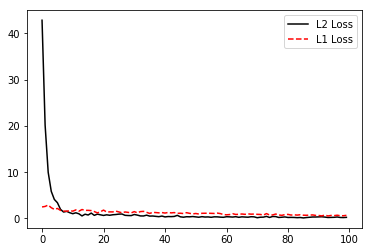

In [18]:
plt.plot(loss_L2,'k-',label='L2 Loss')
plt.plot(loss_L1,'r--',label= 'L1 Loss')
plt.legend(loc='upper right')

# 使用TensorFlow实现逻辑回归算法
### 简介：
逻辑回归算法是可以将线性回归转化为一个2值的分类器（example：0,1）再通过sigmod函数将线性回归的输出缩放到0和1之间。</p>
目标值是0或者1代表着一个属于的是否属于某一类<p>
导入iris数据集<p>
根据目标数据是否为山鸢尾将其转化成1或者0<p>
由于iris数据集将山鸢尾标记为0，我们将其从0置为，同时其他物种标记为0<p>
所以本次训练的目的就是判断给定数据是否为山鸢花<p>


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import normalize
#重新初始化tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()
iris = datasets.load_iris()
x = iris.data
y = np.array([1. if x==0 else 0. for x in iris.target ])


* 分割数据集

将数据分为80%训练集和20%测试集

In [20]:
train_data_index = np.random.choice(len(x),round(len(x)*0.8),replace=False)
test_data_index = np.array(list(set(range(len(x))) - set(train_data_index)))

x_train = x[train_data_index]
x_test = x[test_data_index]
y_train = y[train_data_index]
y_test = y[test_data_index]

为了是收敛效果更好，使用数据归一化操作

In [21]:
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min)/ (col_max-col_min)

x_train = np.nan_to_num(normalize_cols(x_train))
x_test =  np.nan_to_num(normalize_cols(x_test))

* 声明批量大小，占位符，变量和逻辑模型


In [22]:
batch_size = 25
x_data = tf.placeholder(shape=[None,4],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
w = tf.Variable(tf.random_normal(shape=[4,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

In [23]:
output = tf.add(tf.matmul(x_data,w),b)

In [24]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output,labels=y_target))
opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)

与之前不同的是，现在要记录分类器在训练集和测试集的精度</p>
所以我们需要一个计算精度的步骤

In [25]:
prediction = tf.round(tf.sigmoid(output))
prediction_correct = tf.cast(tf.equal(prediction,y_target),tf.float32)
accuracy = tf.reduce_mean(prediction_correct) 

In [26]:
init = tf.global_variables_initializer()
sess.run(init)

In [27]:
epoch=1000
train_loss_result = []
test_loss_result = []
train_acc_result = []
test_acc_result = []
for i in range(epoch):
    rand_index = np.random.choice(len(x_train),size=batch_size)
    rand_x = x_train[rand_index]
    rand_y = np.transpose([y_train[rand_index]])
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
   
    train_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    train_loss_result.append(train_loss)
    
    train_acc = sess.run(accuracy,feed_dict={x_data:rand_x,y_target:rand_y})
    train_acc_result.append(train_acc)    
    
    
    test_loss = sess.run(loss,feed_dict={x_data:x_test,y_target:np.transpose([y_test])})
    test_loss_result.append(test_loss)
    
    test_acc = sess.run(accuracy,feed_dict={x_data:x_test,y_target:np.transpose([y_test])})
    test_acc_result.append(test_acc)  
    
    if (i+1)% 100 ==0:
        print('epoch:{},train loss：{}，train acc：{}，test loss：{}，test acc：{}'.format(i+1,train_loss,train_acc,test_loss,test_acc))

epoch:100,train loss：1.6059755086898804，train acc：0.0，test loss：1.5247522592544556，test acc：0.0
epoch:200,train loss：1.1492921113967896，train acc：0.0，test loss：1.1555744409561157，test acc：0.0
epoch:300,train loss：0.8301514387130737，train acc：0.36000001430511475，test loss：0.9463024139404297，test acc：0.36666667461395264
epoch:400,train loss：0.9153270125389099，train acc：0.6000000238418579，test loss：0.8324056267738342，test acc：0.699999988079071
epoch:500,train loss：0.7718525528907776，train acc：0.6800000071525574，test loss：0.7549755573272705，test acc：0.7333333492279053
epoch:600,train loss：0.8760057091712952，train acc：0.5199999809265137，test loss：0.7000093460083008，test acc：0.7333333492279053
epoch:700,train loss：0.7936550378799438，train acc：0.5600000023841858，test loss：0.6528111696243286，test acc：0.7333333492279053
epoch:800,train loss：0.5742414593696594，train acc：0.7599999904632568，test loss：0.6107610464096069，test acc：0.7333333492279053
epoch:900,train loss：0.5648128986358643，train acc：0

In [ ]:
### 可视化Loss曲线

Text(0.5,0,'generation')

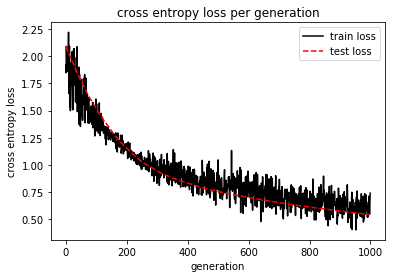

In [29]:
plt.plot(train_loss_result,'k-',label='train loss')
plt.plot(test_loss_result,'r--',label='test loss')
plt.legend(loc='upper right')
plt.title('cross entropy loss per generation')
plt.ylabel('cross entropy loss')
plt.xlabel('generation')

Text(0.5,0,'generation')

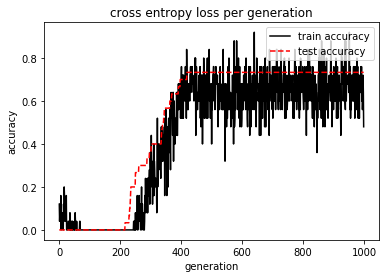

In [30]:
plt.plot(train_acc_result,'k-',label='train accuracy')
plt.plot(test_acc_result,'r--',label='test accuracy')
plt.legend(loc='upper right')
plt.title('cross entropy loss per generation')
plt.ylabel('accuracy')
plt.xlabel('generation')